In [1]:
import numpy as np
import pandas as pd
import os
import zipfile
import cv2
from matplotlib import pyplot as plt
import shutil
from tqdm import tqdm
import torch
import torchvision
import time
import copy
from torchvision import transforms, models
from matplotlib.patches import Rectangle
import csv

In [2]:
data_root = ".\\dataset"
print(os.listdir(data_root))

['test', 'train', 'train_data.csv']


In [3]:
resized = 224

In [4]:
train_dir = "train"
val_dir = "val"
class_names = ["d0_no", "d1_human"]

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, train_dir, class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        img = cv2.imread(os.path.join(source_dir, file_name), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (resized, resized))
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name)
        else:
            dest_dir = os.path.join(val_dir, class_name)
        cv2.imwrite(os.path.join(dest_dir, file_name), img)

100%|██████████| 3/3 [00:00<00:00, 57.45it/s]


In [5]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [6]:
xc = []
yc = []
w = []
h = []

with open(os.path.join(data_root, "train_data.csv"), 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    next(csvreader)
    for row in csvreader:
        xc.append(float(row[1]))
        yc.append(float(row[2]))
        w.append(float(row[3]))
        h.append(float(row[4]))

In [7]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        if original_tuple[1] == 0:
            tuple_new = (original_tuple + (0.001, 0.001, 0.001, 0.001,))
        elif original_tuple[1] == 1:
            id = int(path.split("\\")[2].replace(".jpg", ""))
            tuple_new = (original_tuple + (xc[id], yc[id], w[id], h[id],))
        return tuple_new

In [8]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset = ImageFolderWithPaths(train_dir, train_transforms)
val_dataset = ImageFolderWithPaths(val_dir, val_transforms)

print(train_dataset.samples)

batch_size = 4
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

[('train\\d0_no\\1.jpg', 0), ('train\\d0_no\\2.jpg', 0), ('train\\d1_human\\1.jpg', 1), ('train\\d1_human\\2.jpg', 1)]


In [9]:
len(train_dataloader), len(train_dataset)

(1, 4)

In [54]:
def show_input(input_tensor, num_batch=0, num_elem_batch=0, label=0, xc=0, yc=0, w=0, h=0, draw=False):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    image = image.clip(0, 1)
    plt.imshow(image)
    if draw:
        if label > 0.5:
            print("xc =", xc)
            print("yc =", yc)
            xc = xc * resized
            yc = yc * resized
            print("new xc =", xc)
            print("new yc =", yc)
            start_x = xc - w / 2.
            start_y = yc - h / 2.
            print("start_x =", start_x)
            print("start_y =", start_y)
            if start_x < 0:
                start_x = 0
            if start_y < 0:
                start_y = 0
            if start_x + w > resized:
                w = resized - start_x
            if start_y + h > resized:
                h = resized - start_y
            rect = Rectangle((start_x, start_y), w, h, linewidth=2, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)
            plt.scatter(xc, yc, marker='x', s=100)
    plt.title(str(num_batch) + "." + str(num_elem_batch) + ") " + str(label))
    plt.show()
    plt.pause(0.001)

def show_input_all(dataloader):
    it = iter(dataloader)
    for i in range(len(dataloader)):
        X_batch, y_batch, xc_batch, yc_batch, w_batch, h_batch = next(it)
        print("y_batch:", y_batch)
        print("xc_batch:", xc_batch)
        print("yc_batch:", yc_batch)
        print("w_batch:", w_batch)
        print("h_batch:", h_batch)
        num_elem_batch = 0
        for x_item, y_item, xc_item, yc_item, w_item, h_item in zip(X_batch, y_batch, xc_batch, yc_batch, w_batch, h_batch):
            # show_input(x_item, num_batch=i+1, num_elem_batch=num_elem_batch+1, y_item, xc_item, yc_item, w_item, h_item)
            show_input(x_item, i+1, num_elem_batch+1, y_item.item(), xc_item.item(), yc_item.item(), w_item.item(), h_item.item(), True)
            num_elem_batch += 1

y_batch: tensor([0, 1, 0, 1])
xc_batch: tensor([0.0010, 0.4550, 0.0010, 0.5100], dtype=torch.float64)
yc_batch: tensor([0.0010, 0.2630, 0.0010, 0.4890], dtype=torch.float64)
w_batch: tensor([1.0000e-03, 1.2000e+02, 1.0000e-03, 2.1300e+02], dtype=torch.float64)
h_batch: tensor([1.0000e-03, 1.3800e+02, 1.0000e-03, 2.1700e+02], dtype=torch.float64)


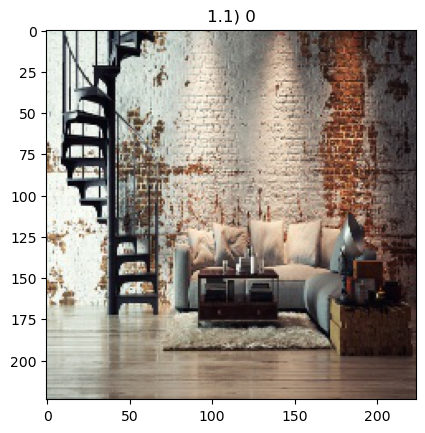

xc = 0.455
yc = 0.263
new xc = 101.92
new yc = 58.912000000000006
start_x = 41.92
start_y = -10.087999999999994


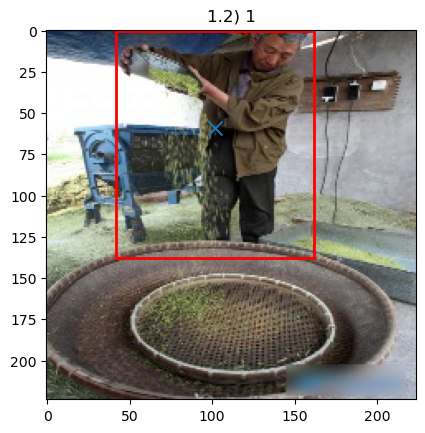

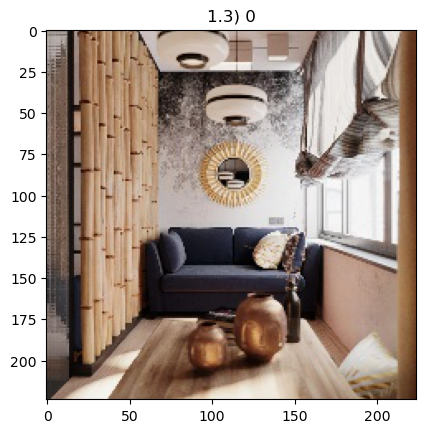

xc = 0.51
yc = 0.489
new xc = 114.24000000000001
new yc = 109.536
start_x = 7.740000000000009
start_y = 1.0360000000000014


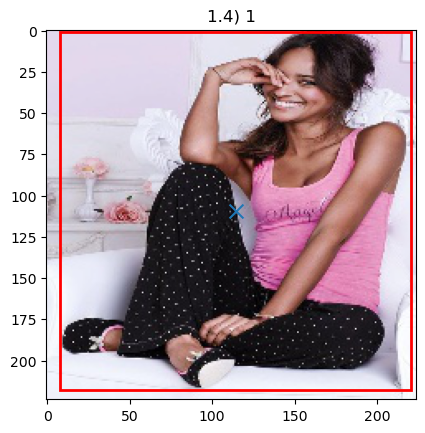

In [55]:
show_input_all(train_dataloader)

y_batch: tensor([0, 1])
xc_batch: tensor([0.0010, 0.4200], dtype=torch.float64)
yc_batch: tensor([0.0010, 0.6520], dtype=torch.float64)
w_batch: tensor([1.0000e-03, 1.1600e+02], dtype=torch.float64)
h_batch: tensor([1.0000e-03, 2.9000e+02], dtype=torch.float64)


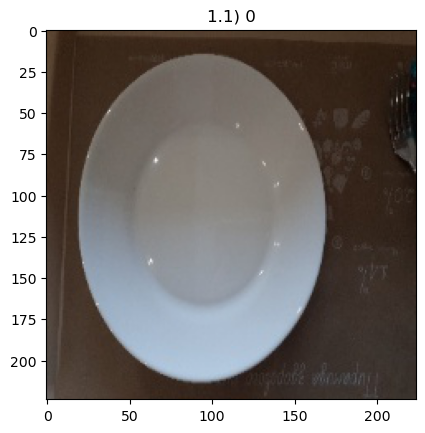

xc = 0.42
yc = 0.652
new xc = 94.08
new yc = 146.048
start_x = 36.08
start_y = 1.0480000000000018


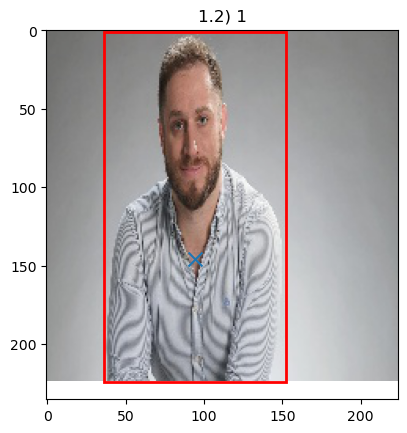

In [56]:
show_input_all(val_dataloader)

In [71]:
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

def train_model(model, sigmoid_act, bce_loss, mse_loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels, xcs, ycs, ws, hs in tqdm(dataloader):
                # inputs = inputs.to(device)
                # labels = labels.to(device)
                # xcs = xcs.to(device)
                # ycs = ycs.to(device)
                # ws = ws.to(device)
                # hs = hs.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)

                    labels = labels.reshape(-1, 1).float()
                    
                    term_labels = bce_loss(sigmoid_act(preds[:, 0:1]), labels)
                    term_xcs = bce_loss(sigmoid_act(preds[:, 1:2]), xcs.reshape(-1, 1).float())
                    term_ycs = bce_loss(sigmoid_act(preds[:, 2:3]), ycs.reshape(-1, 1).float())
                    term_ws = mse_loss(preds[:, 3:4], torch.log(ws.reshape(-1, 1).float()))
                    term_hs = mse_loss(preds[:, 4:5], torch.log(hs.reshape(-1, 1).float()))
                    
                    loss_value = torch.sum(term_labels + labels * (term_xcs + term_ycs + term_ws + term_hs))
                    # print(loss_value)

                    print("preds[:, 0:1]")
                    print(preds[:, 0:1])
                    print("-----------------------")
                    preds_class = torch.tensor([1 if pred.item() > 0.5 else 0 for pred in sigmoid_act(preds[:, 0:1])]).reshape(-1, 1).float()
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                        scheduler.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class.data == labels.data).float().mean()
                print("preds_class.data")
                print(preds_class.data)
                print("labels.data")
                print(labels.data)

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
            if phase == "train":
                train_loss_history.append(epoch_loss)
                train_accuracy_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_accuracy_history.append(epoch_acc)

    return model

In [72]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 5)

# print(torch.cuda.is_available())

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cuda:0" if not torch.cuda.is_available() else "cpu")
# print(device)

sigmoid_act = torch.nn.Sigmoid()

bce_loss = torch.nn.BCELoss()
mse_loss = torch.nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [73]:
tmp = train_model(model, sigmoid_act, bce_loss, mse_loss, optimizer, scheduler, num_epochs=30)

Epoch 0/29:


  0%|          | 0/1 [00:00<?, ?it/s]

preds[:, 0:1]


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]

tensor([[-0.3441],
        [-0.6303],
        [-0.1999],
        [-0.2894]], grad_fn=<SliceBackward0>)
-----------------------
preds_class.data
tensor([[0.],
        [0.],
        [0.],
        [0.]])
labels.data
tensor([[0.],
        [1.],
        [1.],
        [0.]])
train Loss: 147.9564 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00, 11.15it/s]

preds[:, 0:1]
tensor([[ 0.1865],
        [-0.2940]])
-----------------------
preds_class.data
tensor([[1.],
        [0.]])
labels.data
tensor([[0.],
        [1.]])
val Loss: 68.8406 Acc: 0.0000
Epoch 1/29:



100%|██████████| 1/1 [00:00<00:00,  6.70it/s]

preds[:, 0:1]
tensor([[-0.3257],
        [-0.3620],
        [-0.2818],
        [ 0.0630]], grad_fn=<SliceBackward0>)
-----------------------
preds_class.data
tensor([[0.],
        [0.],
        [0.],
        [1.]])
labels.data
tensor([[0.],
        [1.],
        [0.],
        [1.]])
train Loss: 84.9441 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00, 13.37it/s]

preds[:, 0:1]
tensor([[ 0.2271],
        [-0.2209]])
-----------------------
preds_class.data
tensor([[1.],
        [0.]])
labels.data
tensor([[0.],
        [1.]])
val Loss: 73.9312 Acc: 0.0000
Epoch 2/29:



100%|██████████| 1/1 [00:00<00:00,  6.86it/s]

preds[:, 0:1]
tensor([[ 0.2602],
        [-0.3534],
        [-0.3272],
        [-0.1549]], grad_fn=<SliceBackward0>)
-----------------------
preds_class.data
tensor([[1.],
        [0.],
        [0.],
        [0.]])
labels.data
tensor([[1.],
        [0.],
        [0.],
        [1.]])
train Loss: 49.6985 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00, 11.70it/s]

preds[:, 0:1]
tensor([[ 0.2525],
        [-0.1591]])
-----------------------
preds_class.data
tensor([[1.],
        [0.]])
labels.data
tensor([[0.],
        [1.]])
val Loss: 69.5733 Acc: 0.0000
Epoch 3/29:



100%|██████████| 1/1 [00:00<00:00,  7.84it/s]

preds[:, 0:1]
tensor([[-0.4010],
        [ 0.0124],
        [-0.4066],
        [ 0.4154]], grad_fn=<SliceBackward0>)
-----------------------
preds_class.data
tensor([[0.],
        [1.],
        [0.],
        [1.]])
labels.data
tensor([[0.],
        [1.],
        [0.],
        [1.]])
train Loss: 29.8749 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 10.70it/s]

preds[:, 0:1]
tensor([[ 0.2789],
        [-0.1003]])
-----------------------
preds_class.data
tensor([[1.],
        [0.]])
labels.data
tensor([[0.],
        [1.]])
val Loss: 72.8648 Acc: 0.0000
Epoch 4/29:



100%|██████████| 1/1 [00:00<00:00,  6.81it/s]

preds[:, 0:1]
tensor([[ 0.5436],
        [-0.4881],
        [ 0.1537],
        [-0.4728]], grad_fn=<SliceBackward0>)
-----------------------
preds_class.data
tensor([[1.],
        [0.],
        [1.],
        [0.]])
labels.data
tensor([[1.],
        [0.],
        [1.],
        [0.]])
train Loss: 18.6520 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 11.98it/s]

preds[:, 0:1]
tensor([[ 0.3062],
        [-0.0493]])
-----------------------
preds_class.data
tensor([[1.],
        [0.]])
labels.data
tensor([[0.],
        [1.]])
val Loss: 70.5173 Acc: 0.0000
Epoch 5/29:



100%|██████████| 1/1 [00:00<00:00,  6.89it/s]

preds[:, 0:1]
tensor([[ 0.6541],
        [-0.5445],
        [-0.5801],
        [ 0.2772]], grad_fn=<SliceBackward0>)
-----------------------
preds_class.data
tensor([[1.],
        [0.],
        [0.],
        [1.]])
labels.data
tensor([[1.],
        [0.],
        [0.],
        [1.]])
train Loss: 12.2471 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 13.23it/s]

preds[:, 0:1]
tensor([[0.3359],
        [0.0015]])
-----------------------
preds_class.data
tensor([[1.],
        [1.]])
labels.data
tensor([[0.],
        [1.]])
val Loss: 72.4743 Acc: 0.5000
Epoch 6/29:



100%|██████████| 1/1 [00:00<00:00,  7.77it/s]

preds[:, 0:1]
tensor([[ 0.7522],
        [-0.6723],
        [ 0.3880],
        [-0.6178]], grad_fn=<SliceBackward0>)
-----------------------
preds_class.data
tensor([[1.],
        [0.],
        [1.],
        [0.]])
labels.data
tensor([[1.],
        [0.],
        [1.],
        [0.]])
train Loss: 8.5545 Acc: 1.0000



  0%|          | 0/1 [00:00<?, ?it/s]

preds[:, 0:1]


100%|██████████| 1/1 [00:00<00:00, 16.71it/s]

tensor([[0.3674],
        [0.0521]])
-----------------------
preds_class.data
tensor([[1.],
        [1.]])
labels.data
tensor([[0.],
        [1.]])
val Loss: 71.3851 Acc: 0.5000
Epoch 7/29:



100%|██████████| 1/1 [00:00<00:00,  6.93it/s]

preds[:, 0:1]
tensor([[-0.7622],
        [-0.6904],
        [ 0.8413],
        [ 0.4892]], grad_fn=<SliceBackward0>)
-----------------------
preds_class.data
tensor([[0.],
        [0.],
        [1.],
        [1.]])
labels.data
tensor([[0.],
        [0.],
        [1.],
        [1.]])
train Loss: 6.3971 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 14.32it/s]

preds[:, 0:1]
tensor([[0.3820],
        [0.0791]])
-----------------------
preds_class.data
tensor([[1.],
        [1.]])
labels.data
tensor([[0.],
        [1.]])
val Loss: 71.5941 Acc: 0.5000
Epoch 8/29:



100%|██████████| 1/1 [00:00<00:00,  8.12it/s]

preds[:, 0:1]
tensor([[ 0.4986],
        [ 0.8495],
        [-0.7709],
        [-0.6975]], grad_fn=<SliceBackward0>)
-----------------------
preds_class.data
tensor([[1.],
        [1.],
        [0.],
        [0.]])
labels.data
tensor([[1.],
        [1.],
        [0.],
        [0.]])
train Loss: 6.2466 Acc: 1.0000



  0%|          | 0/1 [00:00<?, ?it/s]

preds[:, 0:1]


100%|██████████| 1/1 [00:00<00:00, 14.88it/s]

tensor([[0.4005],
        [0.1055]])
-----------------------
preds_class.data
tensor([[1.],
        [1.]])
labels.data
tensor([[0.],
        [1.]])
val Loss: 71.8178 Acc: 0.5000
Epoch 9/29:



100%|██████████| 1/1 [00:00<00:00,  7.00it/s]

preds[:, 0:1]
tensor([[ 0.5079],
        [-0.7795],
        [-0.7045],
        [ 0.8576]], grad_fn=<SliceBackward0>)
-----------------------
preds_class.data
tensor([[1.],
        [0.],
        [0.],
        [1.]])
labels.data
tensor([[1.],
        [0.],
        [0.],
        [1.]])
train Loss: 6.1052 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 13.42it/s]

preds[:, 0:1]
tensor([[0.4249],
        [0.1307]])
-----------------------
preds_class.data
tensor([[1.],
        [1.]])
labels.data
tensor([[0.],
        [1.]])
val Loss: 71.9788 Acc: 0.5000
Epoch 10/29:



100%|██████████| 1/1 [00:00<00:00,  6.02it/s]

preds[:, 0:1]
tensor([[ 0.5171],
        [-0.7881],
        [-0.7116],
        [ 0.8657]], grad_fn=<SliceBackward0>)
-----------------------
preds_class.data
tensor([[1.],
        [0.],
        [0.],
        [1.]])
labels.data
tensor([[1.],
        [0.],
        [0.],
        [1.]])
train Loss: 5.9718 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 13.28it/s]

preds[:, 0:1]
tensor([[0.4527],
        [0.1532]])
-----------------------
preds_class.data
tensor([[1.],
        [1.]])
labels.data
tensor([[0.],
        [1.]])
val Loss: 72.1663 Acc: 0.5000
Epoch 11/29:



100%|██████████| 1/1 [00:00<00:00,  6.95it/s]

preds[:, 0:1]
tensor([[ 0.8738],
        [ 0.5263],
        [-0.7186],
        [-0.7966]], grad_fn=<SliceBackward0>)
-----------------------
preds_class.data
tensor([[1.],
        [1.],
        [0.],
        [0.]])
labels.data
tensor([[1.],
        [1.],
        [0.],
        [0.]])
train Loss: 5.8455 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 12.10it/s]

preds[:, 0:1]
tensor([[0.4782],
        [0.1736]])
-----------------------
preds_class.data
tensor([[1.],
        [1.]])
labels.data
tensor([[0.],
        [1.]])
val Loss: 72.2597 Acc: 0.5000
Epoch 12/29:



100%|██████████| 1/1 [00:00<00:00,  7.23it/s]

preds[:, 0:1]
tensor([[-0.7256],
        [-0.8051],
        [ 0.8817],
        [ 0.5354]], grad_fn=<SliceBackward0>)
-----------------------
preds_class.data
tensor([[0.],
        [0.],
        [1.],
        [1.]])
labels.data
tensor([[0.],
        [0.],
        [1.],
        [1.]])
train Loss: 5.7254 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 15.05it/s]

preds[:, 0:1]
tensor([[0.5037],
        [0.1930]])
-----------------------
preds_class.data
tensor([[1.],
        [1.]])
labels.data
tensor([[0.],
        [1.]])
val Loss: 72.3427 Acc: 0.5000
Epoch 13/29:



100%|██████████| 1/1 [00:00<00:00,  6.59it/s]

preds[:, 0:1]
tensor([[-0.7325],
        [ 0.5444],
        [-0.8136],
        [ 0.8897]], grad_fn=<SliceBackward0>)
-----------------------
preds_class.data
tensor([[0.],
        [1.],
        [0.],
        [1.]])
labels.data
tensor([[0.],
        [1.],
        [0.],
        [1.]])
train Loss: 5.6112 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 11.60it/s]

preds[:, 0:1]
tensor([[0.5268],
        [0.2106]])
-----------------------
preds_class.data
tensor([[1.],
        [1.]])
labels.data
tensor([[0.],
        [1.]])
val Loss: 72.4459 Acc: 0.5000
Epoch 14/29:



100%|██████████| 1/1 [00:00<00:00,  8.97it/s]

preds[:, 0:1]
tensor([[ 0.5534],
        [-0.7395],
        [ 0.8975],
        [-0.8220]], grad_fn=<SliceBackward0>)
-----------------------
preds_class.data
tensor([[1.],
        [0.],
        [1.],
        [0.]])
labels.data
tensor([[1.],
        [0.],
        [1.],
        [0.]])
train Loss: 5.5023 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 11.35it/s]

preds[:, 0:1]
tensor([[0.5458],
        [0.2241]])
-----------------------
preds_class.data
tensor([[1.],
        [1.]])
labels.data
tensor([[0.],
        [1.]])
val Loss: 72.5040 Acc: 0.5000
Epoch 15/29:



100%|██████████| 1/1 [00:00<00:00,  6.66it/s]

preds[:, 0:1]
tensor([[ 0.5543],
        [ 0.8983],
        [-0.7401],
        [-0.8228]], grad_fn=<SliceBackward0>)
-----------------------
preds_class.data
tensor([[1.],
        [1.],
        [0.],
        [0.]])
labels.data
tensor([[1.],
        [1.],
        [0.],
        [0.]])
train Loss: 5.4918 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 15.60it/s]

preds[:, 0:1]
tensor([[0.5612],
        [0.2375]])
-----------------------
preds_class.data
tensor([[1.],
        [1.]])
labels.data
tensor([[0.],
        [1.]])
val Loss: 72.5935 Acc: 0.5000
Epoch 16/29:



100%|██████████| 1/1 [00:00<00:00,  8.70it/s]

preds[:, 0:1]
tensor([[-0.7408],
        [ 0.5552],
        [ 0.8991],
        [-0.8236]], grad_fn=<SliceBackward0>)
-----------------------
preds_class.data
tensor([[0.],
        [1.],
        [1.],
        [0.]])
labels.data
tensor([[0.],
        [1.],
        [1.],
        [0.]])
train Loss: 5.4813 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 14.67it/s]

preds[:, 0:1]
tensor([[0.5737],
        [0.2489]])
-----------------------
preds_class.data
tensor([[1.],
        [1.]])
labels.data
tensor([[0.],
        [1.]])
val Loss: 72.7339 Acc: 0.5000
Epoch 17/29:



100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

preds[:, 0:1]
tensor([[ 0.8999],
        [-0.8245],
        [-0.7415],
        [ 0.5561]], grad_fn=<SliceBackward0>)
-----------------------
preds_class.data
tensor([[1.],
        [0.],
        [0.],
        [1.]])
labels.data
tensor([[1.],
        [0.],
        [0.],
        [1.]])
train Loss: 5.4709 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 13.51it/s]

preds[:, 0:1]
tensor([[0.5847],
        [0.2599]])
-----------------------
preds_class.data
tensor([[1.],
        [1.]])
labels.data
tensor([[0.],
        [1.]])
val Loss: 72.8700 Acc: 0.5000
Epoch 18/29:



100%|██████████| 1/1 [00:00<00:00,  8.38it/s]

preds[:, 0:1]
tensor([[-0.8253],
        [ 0.9007],
        [ 0.5570],
        [-0.7422]], grad_fn=<SliceBackward0>)
-----------------------
preds_class.data
tensor([[0.],
        [1.],
        [1.],
        [0.]])
labels.data
tensor([[0.],
        [1.],
        [1.],
        [0.]])
train Loss: 5.4606 Acc: 1.0000



  0%|          | 0/1 [00:00<?, ?it/s]

preds[:, 0:1]


100%|██████████| 1/1 [00:00<00:00, 16.96it/s]

tensor([[0.5958],
        [0.2694]])
-----------------------
preds_class.data
tensor([[1.],
        [1.]])
labels.data
tensor([[0.],
        [1.]])
val Loss: 72.9917 Acc: 0.5000
Epoch 19/29:



100%|██████████| 1/1 [00:00<00:00,  8.02it/s]

preds[:, 0:1]
tensor([[-0.8262],
        [-0.7429],
        [ 0.9014],
        [ 0.5579]], grad_fn=<SliceBackward0>)
-----------------------
preds_class.data
tensor([[0.],
        [0.],
        [1.],
        [1.]])
labels.data
tensor([[0.],
        [0.],
        [1.],
        [1.]])
train Loss: 5.4502 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 13.13it/s]

preds[:, 0:1]
tensor([[0.6061],
        [0.2771]])
-----------------------
preds_class.data
tensor([[1.],
        [1.]])
labels.data
tensor([[0.],
        [1.]])
val Loss: 73.0891 Acc: 0.5000
Epoch 20/29:



100%|██████████| 1/1 [00:00<00:00,  7.40it/s]

preds[:, 0:1]
tensor([[-0.8270],
        [ 0.9022],
        [ 0.5588],
        [-0.7436]], grad_fn=<SliceBackward0>)
-----------------------
preds_class.data
tensor([[0.],
        [1.],
        [1.],
        [0.]])
labels.data
tensor([[0.],
        [1.],
        [1.],
        [0.]])
train Loss: 5.4400 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 13.69it/s]

preds[:, 0:1]
tensor([[0.6154],
        [0.2835]])
-----------------------
preds_class.data
tensor([[1.],
        [1.]])
labels.data
tensor([[0.],
        [1.]])
val Loss: 73.1685 Acc: 0.5000
Epoch 21/29:



100%|██████████| 1/1 [00:00<00:00,  8.06it/s]

preds[:, 0:1]
tensor([[-0.8278],
        [ 0.9030],
        [ 0.5597],
        [-0.7443]], grad_fn=<SliceBackward0>)
-----------------------
preds_class.data
tensor([[0.],
        [1.],
        [1.],
        [0.]])
labels.data
tensor([[0.],
        [1.],
        [1.],
        [0.]])
train Loss: 5.4298 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 13.70it/s]

preds[:, 0:1]
tensor([[0.6233],
        [0.2891]])
-----------------------
preds_class.data
tensor([[1.],
        [1.]])
labels.data
tensor([[0.],
        [1.]])
val Loss: 73.2551 Acc: 0.5000
Epoch 22/29:



100%|██████████| 1/1 [00:00<00:00,  7.71it/s]

preds[:, 0:1]
tensor([[-0.8279],
        [ 0.5598],
        [-0.7444],
        [ 0.9031]], grad_fn=<SliceBackward0>)
-----------------------
preds_class.data
tensor([[0.],
        [1.],
        [0.],
        [1.]])
labels.data
tensor([[0.],
        [1.],
        [0.],
        [1.]])
train Loss: 5.4287 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 13.56it/s]

preds[:, 0:1]
tensor([[0.6309],
        [0.2943]])
-----------------------
preds_class.data
tensor([[1.],
        [1.]])
labels.data
tensor([[0.],
        [1.]])
val Loss: 73.3512 Acc: 0.5000
Epoch 23/29:



100%|██████████| 1/1 [00:00<00:00,  5.82it/s]

preds[:, 0:1]
tensor([[ 0.5599],
        [ 0.9032],
        [-0.8280],
        [-0.7444]], grad_fn=<SliceBackward0>)
-----------------------
preds_class.data
tensor([[1.],
        [1.],
        [0.],
        [0.]])
labels.data
tensor([[1.],
        [1.],
        [0.],
        [0.]])
train Loss: 5.4277 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 14.65it/s]

preds[:, 0:1]
tensor([[0.6377],
        [0.2991]])
-----------------------
preds_class.data
tensor([[1.],
        [1.]])
labels.data
tensor([[0.],
        [1.]])
val Loss: 73.4442 Acc: 0.5000
Epoch 24/29:



  0%|          | 0/1 [00:00<?, ?it/s]

preds[:, 0:1]


100%|██████████| 1/1 [00:00<00:00,  8.32it/s]

tensor([[ 0.9032],
        [ 0.5599],
        [-0.8281],
        [-0.7445]], grad_fn=<SliceBackward0>)
-----------------------
preds_class.data
tensor([[1.],
        [1.],
        [0.],
        [0.]])
labels.data
tensor([[1.],
        [1.],
        [0.],
        [0.]])
train Loss: 5.4267 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 14.96it/s]

preds[:, 0:1]
tensor([[0.6444],
        [0.3034]])
-----------------------
preds_class.data
tensor([[1.],
        [1.]])
labels.data
tensor([[0.],
        [1.]])
val Loss: 73.5382 Acc: 0.5000
Epoch 25/29:



100%|██████████| 1/1 [00:00<00:00,  6.84it/s]

preds[:, 0:1]
tensor([[ 0.9033],
        [-0.7446],
        [-0.8282],
        [ 0.5600]], grad_fn=<SliceBackward0>)
-----------------------
preds_class.data
tensor([[1.],
        [0.],
        [0.],
        [1.]])
labels.data
tensor([[1.],
        [0.],
        [0.],
        [1.]])
train Loss: 5.4257 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 16.11it/s]

preds[:, 0:1]
tensor([[0.6506],
        [0.3070]])
-----------------------
preds_class.data
tensor([[1.],
        [1.]])
labels.data
tensor([[0.],
        [1.]])
val Loss: 73.6232 Acc: 0.5000
Epoch 26/29:



100%|██████████| 1/1 [00:00<00:00,  6.92it/s]

preds[:, 0:1]
tensor([[-0.7446],
        [ 0.5601],
        [ 0.9034],
        [-0.8282]], grad_fn=<SliceBackward0>)
-----------------------
preds_class.data
tensor([[0.],
        [1.],
        [1.],
        [0.]])
labels.data
tensor([[0.],
        [1.],
        [1.],
        [0.]])
train Loss: 5.4247 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 14.51it/s]

preds[:, 0:1]
tensor([[0.6563],
        [0.3099]])
-----------------------
preds_class.data
tensor([[1.],
        [1.]])
labels.data
tensor([[0.],
        [1.]])
val Loss: 73.7104 Acc: 0.5000
Epoch 27/29:



  0%|          | 0/1 [00:00<?, ?it/s]

preds[:, 0:1]


100%|██████████| 1/1 [00:00<00:00,  8.62it/s]

tensor([[-0.7447],
        [ 0.5602],
        [-0.8283],
        [ 0.9035]], grad_fn=<SliceBackward0>)
-----------------------
preds_class.data
tensor([[0.],
        [1.],
        [0.],
        [1.]])
labels.data
tensor([[0.],
        [1.],
        [0.],
        [1.]])
train Loss: 5.4237 Acc: 1.0000



  0%|          | 0/1 [00:00<?, ?it/s]

preds[:, 0:1]


100%|██████████| 1/1 [00:00<00:00, 14.36it/s]

tensor([[0.6614],
        [0.3125]])
-----------------------
preds_class.data
tensor([[1.],
        [1.]])
labels.data
tensor([[0.],
        [1.]])
val Loss: 73.7917 Acc: 0.5000
Epoch 28/29:



100%|██████████| 1/1 [00:00<00:00,  9.81it/s]

preds[:, 0:1]
tensor([[ 0.5603],
        [ 0.9035],
        [-0.7448],
        [-0.8284]], grad_fn=<SliceBackward0>)
-----------------------
preds_class.data
tensor([[1.],
        [1.],
        [0.],
        [0.]])
labels.data
tensor([[1.],
        [1.],
        [0.],
        [0.]])
train Loss: 5.4226 Acc: 1.0000



  0%|          | 0/1 [00:00<?, ?it/s]

preds[:, 0:1]


100%|██████████| 1/1 [00:00<00:00, 14.66it/s]

tensor([[0.6662],
        [0.3149]])
-----------------------
preds_class.data
tensor([[1.],
        [1.]])
labels.data
tensor([[0.],
        [1.]])
val Loss: 73.8703 Acc: 0.5000
Epoch 29/29:



100%|██████████| 1/1 [00:00<00:00,  7.28it/s]

preds[:, 0:1]
tensor([[-0.7448],
        [-0.8284],
        [ 0.9035],
        [ 0.5603]], grad_fn=<SliceBackward0>)
-----------------------
preds_class.data
tensor([[0.],
        [0.],
        [1.],
        [1.]])
labels.data
tensor([[0.],
        [0.],
        [1.],
        [1.]])
train Loss: 5.4225 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00, 13.76it/s]

preds[:, 0:1]
tensor([[0.6706],
        [0.3169]])
-----------------------
preds_class.data
tensor([[1.],
        [1.]])
labels.data
tensor([[0.],
        [1.]])
val Loss: 73.9379 Acc: 0.5000


In [74]:
losses = {}
accuracies = {}

losses['train'], accuracies['train'] = train_loss_history, [elem.item() for elem in train_accuracy_history]
losses['val'], accuracies['val'] = val_loss_history, [elem.item() for elem in val_accuracy_history]

[147.9564208984375, 84.944091796875, 49.69847869873047, 29.874855041503906, 18.651954650878906, 12.24708366394043, 8.55445384979248, 6.397068977355957, 6.2465739250183105, 6.105227470397949, 5.97182559967041, 5.845458984375, 5.725429534912109, 5.611185073852539, 5.502279758453369, 5.491780757904053, 5.481321811676025, 5.470917701721191, 5.460559844970703, 5.4502482414245605, 5.439980506896973, 5.42976188659668, 5.4287428855896, 5.427726745605469, 5.426707744598389, 5.425692558288574, 5.424675464630127, 5.423659324645996, 5.422641277313232, 5.422542572021484]
[68.8405532836914, 73.93119812011719, 69.57334899902344, 72.86481475830078, 70.51728820800781, 72.47428894042969, 71.38505554199219, 71.59408569335938, 71.81784057617188, 71.978759765625, 72.16627502441406, 72.25968933105469, 72.3426513671875, 72.44593048095703, 72.50401306152344, 72.59351348876953, 72.73394775390625, 72.86995697021484, 72.99169921875, 73.08908081054688, 73.16848754882812, 73.255126953125, 73.35121154785156, 73.444

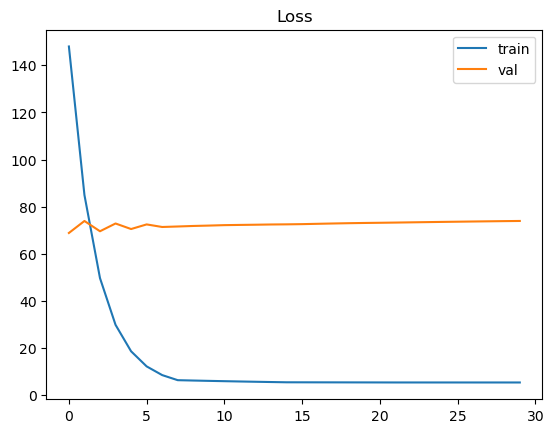

In [75]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Loss')
print(losses['train'])
print(losses['val'])

[0.5, 0.75, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


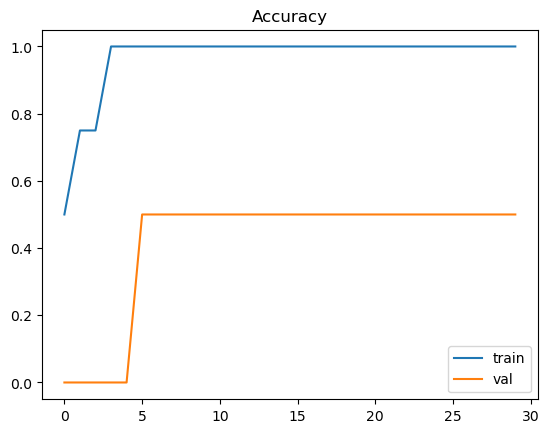

In [76]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Accuracy')
print(accuracies['train'])
print(accuracies['val'])

In [58]:
test_dir = "test"
class_name = "unknown"

os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

source_dir = os.path.join(data_root, test_dir)
for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
    img = cv2.imread(os.path.join(source_dir, file_name), cv2.IMREAD_COLOR)
    img = cv2.resize(img, (resized, resized))
    dest_dir = os.path.join(test_dir, class_name)
    cv2.imwrite(os.path.join(dest_dir, file_name), img)

100%|██████████| 3/3 [00:00<00:00, 65.66it/s]


In [59]:
test_dataset = torchvision.datasets.ImageFolder(test_dir, val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [60]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 3
    Root location: test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485 0.456 0.406], std=[0.229 0.224 0.225])
           )

In [77]:
model.eval()

test_predictions = []

for inputs, labels in tqdm(test_dataloader):
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(preds)

100%|██████████| 1/1 [00:00<00:00,  7.68it/s]


tensor([ 0.3683, -0.9199, -1.5690,  0.3248,  2.3970])
0.28498080372810364
0.17235206067562103
xc = 0.28498080372810364
yc = 0.17235206067562103
new xc = 63.835700035095215
new yc = 38.60686159133911
start_x = 63.14380693435669
start_y = 33.11179208755493


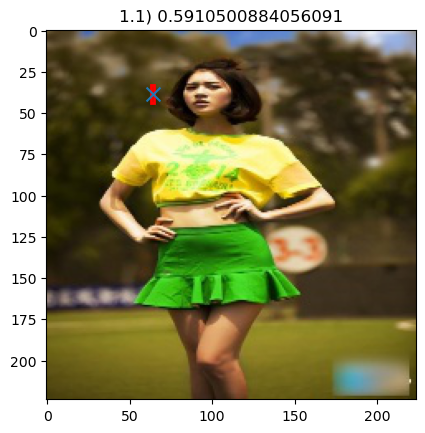

tensor([ 0.3677, -0.9761, -1.3067, -0.2399, -0.1183])
0.27366235852241516
0.21304042637348175
xc = 0.27366235852241516
yc = 0.21304042637348175
new xc = 61.300368309020996
new yc = 47.72105550765991
start_x = 60.90702486038208
start_y = 47.2768312394619


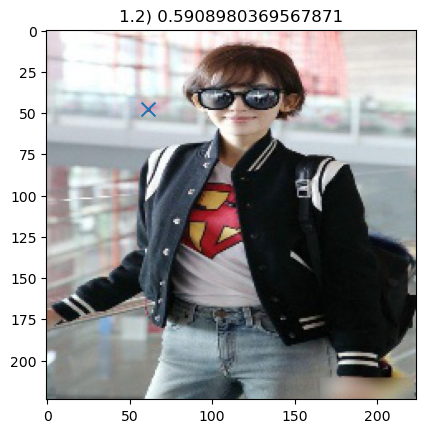

tensor([ 0.3169, -1.2796, -0.3860,  1.1765,  1.3931])
0.21762293577194214
0.4046708941459656
xc = 0.21762293577194214
yc = 0.4046708941459656
new xc = 48.74753761291504
new yc = 90.64628028869629
start_x = 47.12608754634857
start_y = 88.63264513015747


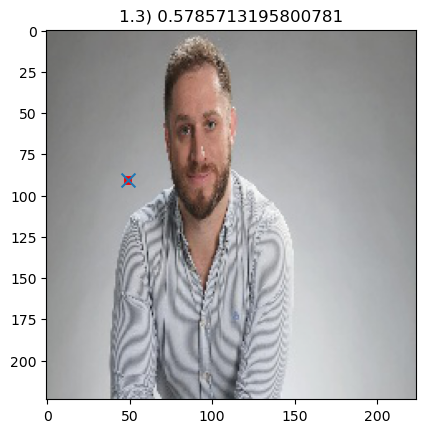

In [78]:
it = iter(test_dataloader)
for i in range(len(test_dataloader)):
    inputs, labels = next(it)
    num_elem_batch = 0
    for img, pred in zip(inputs, test_predictions[i]):
        print(pred)
        # print(pred[0])
        # print(sigmoid_act(pred[0]).item())
        print(sigmoid_act(pred[1]).item())
        print(sigmoid_act(pred[2]).item())
        # print(torch.exp(pred[3]))
        # print(torch.exp(pred[3]).item())
        show_input(img, i+1, num_elem_batch+1, sigmoid_act(pred[0]).item(), sigmoid_act(pred[1]).item(), sigmoid_act(pred[2]).item(), torch.exp(pred[3]).item(), torch.exp(pred[4]).item(), True)
        num_elem_batch += 1

In [2]:
# !rm -rf train val test